### The dataset: UCI Credit-card defaults

We use the UCI dataset on credit-card defaults in 2005 in Taiwan. For the sake of this exercise, we modify the original UCI dataset: we introduce a synthetic feature that has a strong predictive power for female clients, but is uninformative for male applicants. We fit a variety of models for predicting the default of a client. We show that a fairness-unaware training algorithm can lead to a predictor that achieves a much better accuracy for women than for men, and that it is insufficient to simply remove the sensitive feature (in this case sex) from training. 

In [3]:
#Install a conda package in the current Jupyter kernel
#LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient
import sys
!conda install --yes --prefix {sys.prefix} lightgbm

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\hatta\anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38haa244fe_0         3.1 MB  conda-forge
    lightgbm-3.1.0             |   py38h885f38d_0         751 KB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.8 MB

The following NEW packages will be INSTALLED:

  lightgbm           conda-forge/win-64::lightgbm-3.1.0-py38h885f38d_0
  python_abi         conda-forge/win-64::python_abi-3.8-1_cp38

The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.3-py38_0 --> conda-forge::conda-4.9.2-py38haa244fe_0




conda-4



==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda




In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
#Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds
from fairlearn.widget import FairlearnDashboard
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [5]:
# Load the data
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = pd.read_excel(io=data_url, header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# Extract the sensitive feature
A = dataset["SEX"]
A_str = A.map({ 2:"female", 1:"male"})
# Extract the target
Y = dataset["default payment next month"]
categorical_features = ['EDUCATION', 'MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in categorical_features:
    dataset[col] = dataset[col].astype('category')

In [7]:
#manipulate the balance-limit feature LIMIT_BAL to make it highly predictive for women but not for men.
dist_scale = 0.5
np.random.seed(12345)
# Make 'LIMIT_BAL' informative of the target
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])
# But then make it uninformative for the male clients
dataset.loc[A==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=dataset[A==1].shape[0])

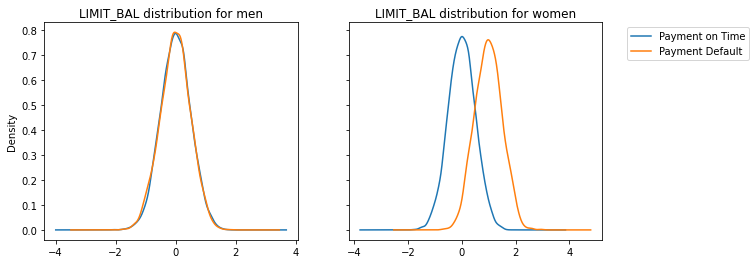

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# Plot distribution of LIMIT_BAL for men
dataset['LIMIT_BAL'][(A==1) & (Y==0)].plot(kind='kde', label="Payment on Time", ax=ax1, 
                                           title="LIMIT_BAL distribution for men")
dataset['LIMIT_BAL'][(A==1) & (Y==1)].plot(kind='kde', label="Payment Default", ax=ax1)
# Plot distribution of LIMIT_BAL for women
dataset['LIMIT_BAL'][(A==2) & (Y==0)].plot(kind='kde', label="Payment on Time", ax=ax2, 
                                           legend=True, title="LIMIT_BAL distribution for women")
dataset['LIMIT_BAL'][(A==2) & (Y==1)].plot(kind='kde', label="Payment Default", ax=ax2, 
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

In [9]:
# Train-test split
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    dataset.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

### Using a fairness-unaware model

In [10]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

model = lgb.LGBMClassifier(**lgb_params)
model.fit(df_train, Y_train)

# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]
test_scores

array([0.41351351, 0.85867336, 0.08626319, ..., 0.46370207, 0.06082614,
       0.09842035])

In [12]:
# Train AUC
roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1])
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1
test_preds

array([1, 1, 0, ..., 1, 0, 0])

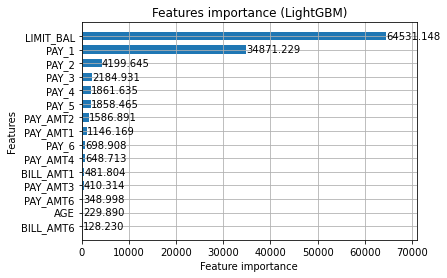

In [13]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
plt.show()

In [15]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "-----": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(balanced_accuracy_score, y_true, x, sensitive_features=group).difference(method='between_groups'), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(roc_auc_score, y_true, x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated
Overall selection rate,0.268111
Demographic parity difference,0.0511053
Demographic parity ratio,0.8225
-----,
Overall balanced error rate,0.220682
Balanced error rate difference,0.175789
Equalized odds difference,0.342283
------,
Overall AUC,0.851931
AUC difference,0.189712


__NOTE:__ As the fairness metric we use equalized odds difference, which quantifies the disparity in accuracy experienced by different demographics. Our goal is to assure that neither of the two groups (men vs women) has substantially larger false-positive rates or false-negative rates than the other group. The equalized odds difference is equal to the larger of the following two numbers: (1) the difference between false-positive rates of the two groups, (2) the difference between false-negative rates of the two groups.

## Mitigating with Threshold Optimizer

We attempt to mitigate the disparities in the lightgbm predictions using the Fairlearn postprocessing algorithm ThresholdOptimizer. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the lightgbm model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that __ThresholdOptimizer is effectively optimizing balanced accuracy__ on the original data.

In [16]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds")

# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)

df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.268111,0.224
Demographic parity difference,0.0511053,0.0129613
Demographic parity ratio,0.8225,0.944117
-----,,
Overall balanced error rate,0.220682,0.32296
Balanced error rate difference,0.175789,0.00201698
Equalized odds difference,0.342283,0.00264508
------,,
Overall AUC,0.851931,0.67704
AUC difference,0.189712,0.00201698


The ThresholdOptimizer algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

## Mitigating with GridSearch Optimizer

We now attempt to mitigate disparities using the GridSearch algorithm. Unlike ThresholdOptimizer, the predictors produced by GridSearch do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

In [18]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=41,
                   grid_limit=2)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_]

equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


In [23]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

## Mitigating with Exponantiated Gradient

In [25]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint=EqualizedOdds()

mitigator = ExponentiatedGradient(model, constraint)
mitigator.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)
y_pred_mitigated = mitigator.predict(df_test)

In [27]:
equalized_odds_eg = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]


models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds),
              "ExponentialGradient": (y_pred_mitigated, y_pred_mitigated), 
              "GridSearch_min": (sweep_preds[1], sweep_preds[1])}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer,ExponentialGradient,GridSearch_min
Overall selection rate,0.268111,0.224,0.263333,0.235333
Demographic parity difference,0.0511053,0.0129613,0.0259775,0.13849
Demographic parity ratio,0.8225,0.944117,0.906972,0.520806
-----,,,,
Overall balanced error rate,0.220682,0.32296,0.278561,0.294443
Balanced error rate difference,0.175789,0.00201698,0.0322446,0.32337
Equalized odds difference,0.342283,0.00264508,0.0394038,0.652404
------,,,,
Overall AUC,0.851931,0.67704,0.721439,0.705557
AUC difference,0.189712,0.00201698,0.0322446,0.32337


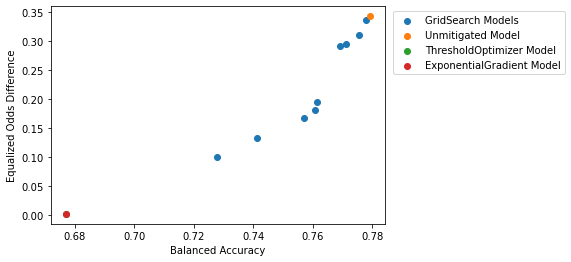

In [34]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ExponentialGradient Model")

plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

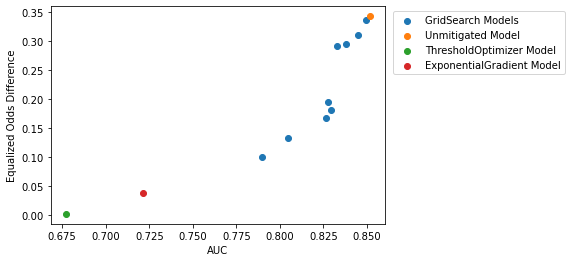

In [35]:
# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.scatter(roc_auc_score(Y_test, y_pred_mitigated), 
            equalized_odds_difference(Y_test, y_pred_mitigated, sensitive_features=A_str_test),
            label="ExponentialGradient Model")

plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

In [36]:
model_sweep_dict = {"GridSearch_{}".format(i): sweep_preds[i] for i in range(len(sweep_preds)) if non_dominated[i]}
model_sweep_dict.update({"Unmitigated": test_preds, "ThresholdOptimizer": postprocess_preds, 
                         "Exponential Gradient": y_pred_mitigated})

In [37]:
#dashboard
FairlearnDashboard(sensitive_features=A_str_test, sensitive_feature_names=['Sex'],
                   y_true=Y_test,
                   y_pred=model_sweep_dict)

C:\Users\hatta\anaconda3\lib\site-packages\fairlearn\widget\_fairlearn_dashboard.py:47: UserWarning: The FairlearnDashboard will move from Fairlearn to the raiwidgets package after the v0.5.0 release. Instead, Fairlearn will provide some of the existing functionality through matplotlib-based visualizations.
  warn("The FairlearnDashboard will move from Fairlearn to the "


FairlearnWidget(value={'true_y': [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1…